<a href="https://colab.research.google.com/github/A-Tetarwal/AI-367-Grp-37-Submissions/blob/main/Earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LINEAR REGRESSION MODEL

# Required Imports

In [ ]:
import pandas as pd
import numpy as np
import folium
import webbrowser
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.compose import ColumnTransformer
from google.colab import files

# Data Loading and Preprocessing

In [ ]:
def load_earthquake_data(filename):

    # Load data and convert datetime
    data = pd.read_csv(filename)
    data['date_time'] = pd.to_datetime(data['date_time'], format='%d-%m-%Y %H:%M')

    # Validate required columns
    required_columns = ['magnitude', 'latitude', 'longitude', 'depth', 'date_time']
    if not all(col in data.columns for col in required_columns):
        raise ValueError(f"Missing required columns: {set(required_columns) - set(data.columns)}")

    # Clean data
    columns_to_clean = ['magnitude', 'latitude', 'longitude', 'depth']
    data = data.dropna(subset=columns_to_clean + ['date_time'])
    data = data.reset_index(drop=True)

    # Handle outliers using RobustScaler
    scaler = RobustScaler()
    data_scaled = pd.DataFrame(
        scaler.fit_transform(data[columns_to_clean]),
        columns=columns_to_clean,
        index=data.index
    )

    # Remove outliers (beyond 3 standard deviations)
    combined_mask = pd.Series(True, index=data.index)
    for col in columns_to_clean:
        combined_mask &= np.abs(data_scaled[col]) <= 3

    data = data[combined_mask].copy()

    # Validate data ranges
    validation_mask = (
        (data['magnitude'] >= 0) &
        (data['magnitude'] <= 10) &
        (data['depth'] >= 0) &
        (data['latitude'].between(-90, 90)) &
        (data['longitude'].between(-180, 180))
    )

    return data[validation_mask].reset_index(drop=True)

# Feature Engineering

In [ ]:
def create_features(data):

    features = pd.DataFrame()

    # Basic features
    features['magnitude'] = data['magnitude']
    features['depth'] = data['depth']
    features['latitude'] = data['latitude']
    features['longitude'] = data['longitude']

    # Time-based features
    features['year'] = data['date_time'].dt.year
    features['month'] = data['date_time'].dt.month
    features['day_of_year'] = data['date_time'].dt.dayofyear
    features['hour'] = data['date_time'].dt.hour
    features['day_of_week'] = data['date_time'].dt.dayofweek

    # Interaction features
    features['lat_lon'] = data['latitude'] * data['longitude']
    features['depth_mag'] = data['depth'] * data['magnitude']

    # Non-linear transformations
    features['depth_scaled'] = np.log1p(data['depth'])
    features['magnitude_squared'] = data['magnitude'] ** 2

    # Cyclical features for temporal data
    features['month_sin'] = np.sin(data['date_time'].dt.month * (2 * np.pi / 12))
    features['month_cos'] = np.cos(data['date_time'].dt.month * (2 * np.pi / 12))
    features['hour_sin'] = np.sin(data['date_time'].dt.hour * (2 * np.pi / 24))
    features['hour_cos'] = np.cos(data['date_time'].dt.hour * (2 * np.pi / 24))
    features['day_of_week_sin'] = np.sin(data['date_time'].dt.dayofweek * (2 * np.pi / 7))
    features['day_of_week_cos'] = np.cos(data['date_time'].dt.dayofweek * (2 * np.pi / 7))

    # Geographic features
    features['distance_from_equator'] = np.abs(data['latitude'])
    features['hemisphere_ns'] = np.sign(data['latitude'])
    features['hemisphere_ew'] = np.sign(data['longitude'])

    return features

# Model Building

In [ ]:
def build_model(X, y):

    # Create preprocessor for numeric features
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features)
        ]
    )

    # Create pipeline with feature selection and polynomial features
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', SelectPercentile(f_regression, percentile=90)),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=0.01, max_iter=10000))
    ])

    return pipeline.fit(X, y)

# Prediction Generation

In [ ]:
def predict_earthquakes(model, location, time_period_years=10, num_predictions=20):

    predictions = []
    current_date = pd.Timestamp.now()

    for _ in range(num_predictions):
        # Generate future dates and parameters
        days_in_future = np.random.randint(1, time_period_years * 365)
        future_date = current_date + pd.Timedelta(days=days_in_future)

        hour = np.random.randint(0, 24)
        depth = np.random.exponential(scale=20)
        base_magnitude = np.random.normal(5, 0.5)

        # Create feature set for prediction
        features = pd.DataFrame({
            'magnitude': [base_magnitude],
            'depth': [depth],
            'latitude': [location[0] + np.random.normal(0, 0.2)],
            'longitude': [location[1] + np.random.normal(0, 0.2)],
            'year': [future_date.year],
            'month': [future_date.month],
            'day_of_year': [future_date.dayofyear],
            'hour': [hour],
            'day_of_week': [future_date.dayofweek],
            'lat_lon': [location[0] * location[1]],
            'depth_mag': [depth * base_magnitude],
            'depth_scaled': [np.log1p(depth)],
            'magnitude_squared': [base_magnitude ** 2],
            'month_sin': [np.sin(future_date.month * (2 * np.pi / 12))],
            'month_cos': [np.cos(future_date.month * (2 * np.pi / 12))],
            'hour_sin': [np.sin(hour * (2 * np.pi / 24))],
            'hour_cos': [np.cos(hour * (2 * np.pi / 24))],
            'day_of_week_sin': [np.sin(future_date.dayofweek * (2 * np.pi / 7))],
            'day_of_week_cos': [np.cos(future_date.dayofweek * (2 * np.pi / 7))],
            'distance_from_equator': [np.abs(location[0])],
            'hemisphere_ns': [np.sign(location[0])],
            'hemisphere_ew': [np.sign(location[1])]
        })

        # Generate prediction
        magnitude = model.predict(features)[0]
        predictions.append({
            'latitude': features['latitude'].iloc[0],
            'longitude': features['longitude'].iloc[0],
            'magnitude': magnitude,
            'depth': depth,
            'date': future_date,
            'time_diff_years': days_in_future / 365.25
        })

    return predictions

# Visualization Functions


In [ ]:
def visualize_predictions(data, predictions):
    # 1. Historical Magnitude Distribution
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    sns.histplot(data['magnitude'], bins=50)
    plt.title('Historical Magnitude Distribution')

    # 2. Depth vs Magnitude Scatter Plot
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=data, x='depth', y='magnitude', alpha=0.5)
    plt.title('Depth vs Magnitude Relationship')

    # 3. Geographical Heatmap
    plt.subplot(2, 2, 3)
    plt.hist2d(data['longitude'], data['latitude'], bins=50, cmap='hot')
    plt.colorbar(label='Frequency')
    plt.title('Earthquake Frequency Heatmap')

    # 4. Predicted Magnitudes Timeline
    pred_df = pd.DataFrame(predictions)
    plt.subplot(2, 2, 4)
    plt.scatter(pred_df['time_diff_years'], pred_df['magnitude'])
    plt.xlabel('Years in Future')
    plt.ylabel('Predicted Magnitude')
    plt.title('Predicted Earthquakes Timeline')

    plt.tight_layout()
    plt.savefig('earthquake_analysis.png')
    files.download('earthquake_analysis.png')

def create_interactive_map(predictions):
    # Create base map centered on mean coordinates
    center_lat = np.mean([p['latitude'] for p in predictions])
    center_lon = np.mean([p['longitude'] for p in predictions])
    world_map = folium.Map(location=[center_lat, center_lon], zoom_start=8)

    # Add prediction markers with enhanced popups
    for event in predictions:
        magnitude = event['magnitude']
        color = 'green' if magnitude < 5 else 'orange' if magnitude < 6 else 'red'

        popup_html = f"""
            <div style='width:200px'>
                <h4>Predicted Earthquake</h4>
                <p><b>Magnitude:</b> {magnitude:.2f}</p>
                <p><b>Depth:</b> {event['depth']:.1f} km</p>
                <p><b>Expected in:</b> {event['time_diff_years']:.1f} years</p>
                <p><b>Date:</b> {event['date'].strftime('%Y-%m-%d')}</p>
            </div>
        """

        folium.CircleMarker(
            location=[event['latitude'], event['longitude']],
            radius=magnitude * 2,
            popup=folium.Popup(popup_html, max_width=300),
            color=color,
            fill=True,
            fillOpacity=0.7
        ).add_to(world_map)

    # Add legend
    legend_html = '''
        <div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background-color: white; padding: 10px; border: 2px solid grey; border-radius: 5px;">
            <p><span style="color: green;">●</span> Magnitude < 5</p>
            <p><span style="color: orange;">●</span> Magnitude 5-6</p>
            <p><span style="color: red;">●</span> Magnitude > 6</p>
        </div>
    '''
    world_map.get_root().html.add_child(folium.Element(legend_html))

    return world_map

# Model Evaluation

In [ ]:
def evaluate_model(model, X_test, y_test, features, target):

    # Calculate prediction metrics
    y_pred = model.predict(X_test)
    metrics = {
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R²': r2_score(y_test, y_pred)
    }

    # Perform time-series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = cross_val_score(model, features, target, cv=tscv,
                              scoring='neg_mean_squared_error')

    return metrics, cv_scores


# Main Execution Function

Model Metrics: {'MSE': 4.879880758925107e-10, 'RMSE': 2.209045214323398e-05, 'MAE': 1.1976289885640784e-05, 'R²': 0.9999999970769202}
Cross-validation MSE: 3.7673684525085126e-07
Cross-validation Std Dev: 4.395538581221151e-07


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

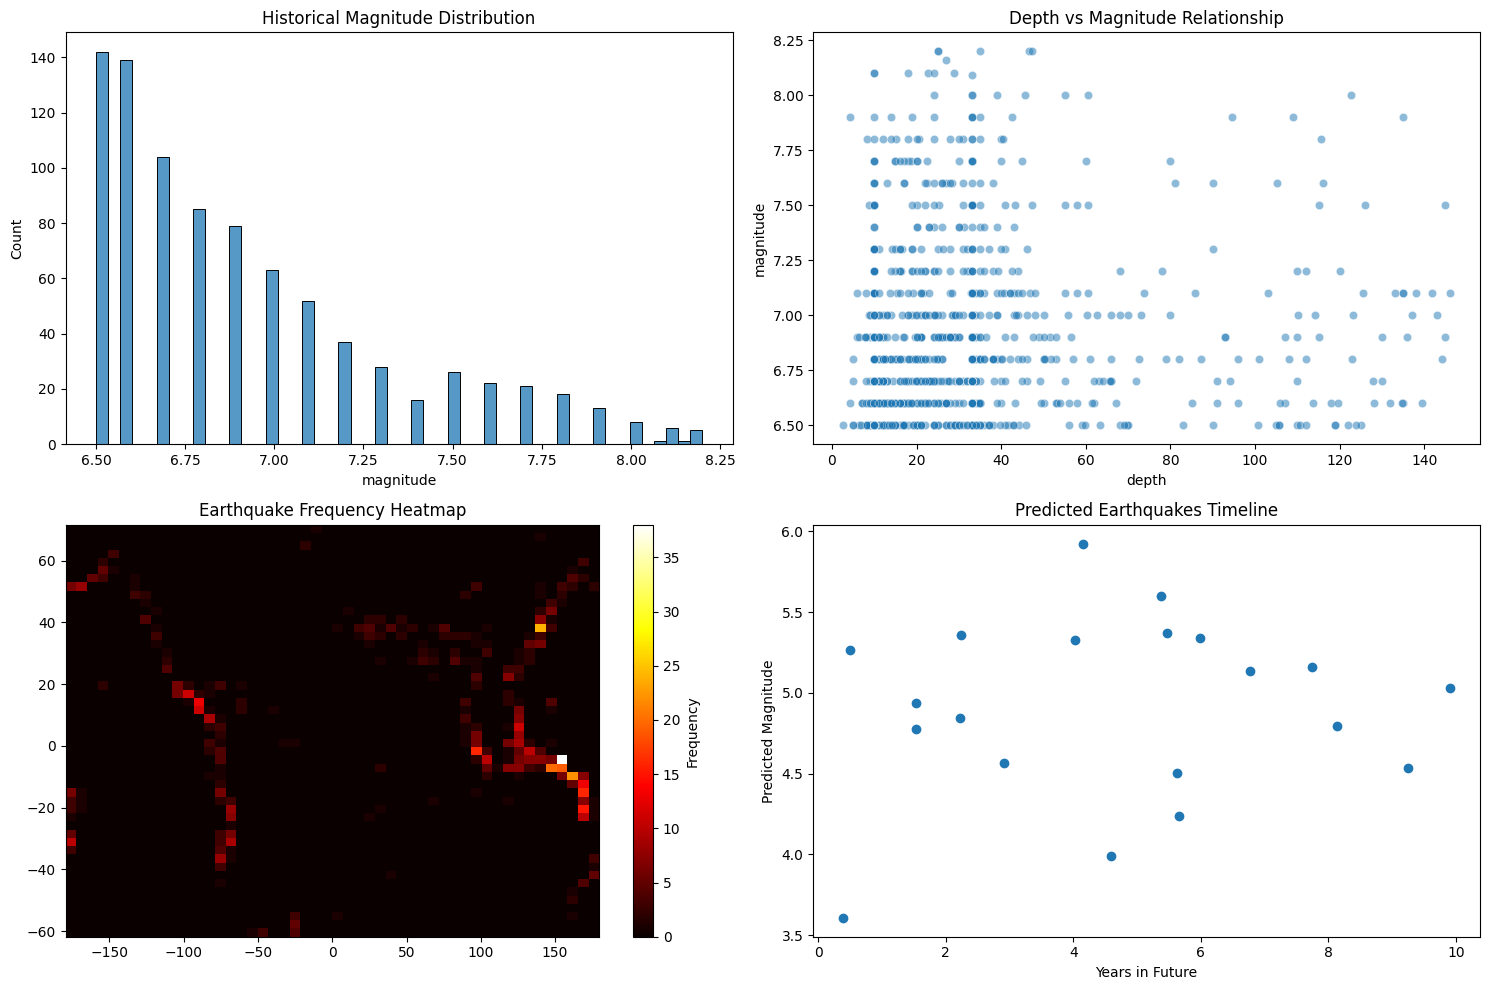

In [ ]:
def main():

    # Load and prepare data
    data = load_earthquake_data('earthquake.csv')
    features = create_features(data)

    # Split data for training
    X_train, X_test, y_train, y_test = train_test_split(
        features, data['magnitude'], test_size=0.2, random_state=42
    )

    # Build and evaluate model
    model = build_model(X_train, y_train)
    metrics, cv_scores = evaluate_model(model, X_test, y_test, features, data['magnitude'])

    # Print evaluation results
    print("Model Metrics:", metrics)
    print("Cross-validation MSE:", -cv_scores.mean())
    print("Cross-validation Std Dev:", cv_scores.std())

    # Generate predictions for Los Angeles
    location = (34.0522, -118.2437)  # Los Angeles
    predicted_events = predict_earthquakes(model, location)

    # Create visualizations
    visualize_predictions(data, predicted_events)

    # Create and save interactive map
    world_map = create_interactive_map(predicted_events)
    world_map.save('earthquake_predictions_map.html')
    webbrowser.open('earthquake_predictions_map.html')
    files.download('earthquake_predictions_map.html')

if __name__ == "__main__":
    main()